In [9]:
import pandas as pd


df = pd.read_csv("startup_funding.csv")

df.head()


,Sr No,Date dd/mm/yyyy,Startup Name,Industry Vertical,SubVertical,City Location,Investors Name,InvestmentnType,Amount in USD,Remarks
0,1,09/01/2020,BYJU’S,E-Tech,E-learning,Bengaluru,Tiger Global Management,Private Equity Round,"20,00,00,000",NaN
1,2,13/01/2020,Shuttl,Transportation,App based shuttle service,Gurgaon,Susquehanna Growth Equity,Series C,"80,48,394",NaN
2,3,09/01/2020,Mamaearth,E-commerce,Retailer of baby and toddler products,Bengaluru,Sequoia Capital India,Series B,"1,83,58,860",NaN
3,4,02/01/2020,https://www.wealthbucket.in/,FinTech,Online Investment,New Delhi,Vinod Khatumal,Pre-series A,"30,00,000",NaN
4,5,02/01/2020,Fashor,Fashion and Apparel,Embroiled Clothes For Women,Mumbai,Sprout Venture Partners,Seed Round,"18,00,000",NaN


In [12]:
# -------------------------------M
# Startup Growth Analytics - Advanced version
# -------------------------------

i
import numpy as np
import plotly.express as px
from dash import Dash, dcc, html, Input, Output
import dash_bootstrap_components as dbc
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv("startup_funding.csv")  


df.columns = ['SrNo','Date','StartupName','Industry','SubVertical','City','Investors','InvestmentType','AmountUSD','Remarks']


dates = []
for d in df['Date']:
    try:
        dates.append(pd.to_datetime(d, format='%d/%m/%Y'))
    except:
        dates.append(pd.NaT)
df['Date'] = dates


amounts = []
for amt in df['AmountUSD']:
    try:
        amt = str(amt).replace(',', '')
        amounts.append(float(amt))
    except:
        amounts.append(np.nan)
df['AmountUSD'] = amounts


cities = []
for c in df['City']:
    if pd.isna(c):
        cities.append('Unknown')
    else:
        c = str(c).strip()
        if c == 'Bangalore':
            c = 'Bengaluru'
        cities.append(c)
df['City'] = cities

industries = []
for ind in df['Industry']:
    if pd.isna(ind):
        industries.append('Unknown')
    else:
        industries.append(str(ind).strip())
df['Industry'] = industries

investment_types = []
for inv in df['InvestmentType']:
    if pd.isna(inv):
        investment_types.append('Unknown')
    else:
        investment_types.append(str(inv).strip())
df['InvestmentType'] = investment_types

remarks = []
for r in df['Remarks']:
    if pd.isna(r):
        remarks.append('None')
    else:
        remarks.append(str(r))
df['Remarks'] = remarks


df = df[df['AmountUSD'].notna()]


df = df.drop_duplicates()

# -------------------------------
#  Feature Engineering
# -------------------------------
success_list = []
years = []
months = []

for i, row in df.iterrows():
    # Success if funding > 1 million
    if row['AmountUSD'] > 1000000:
        success_list.append(1)
    else:
        success_list.append(0)
    
    # Year and Month
    if pd.notna(row['Date']):
        years.append(row['Date'].year)
        months.append(row['Date'].month)
    else:
        years.append(np.nan)
        months.append(np.nan)

df['Success'] = success_list
df['Year'] = years
df['Month'] = months


le_city = LabelEncoder()
df['City_enc'] = le_city.fit_transform(df['City'])

le_industry = LabelEncoder()
df['Industry_enc'] = le_industry.fit_transform(df['Industry'])




fig_funding = px.histogram(df, x='AmountUSD', nbins=50, marginal="box",
                           title='Funding Amount Distribution', template='plotly_dark')
fig_funding.update_layout(xaxis_title='Amount in USD', yaxis_title='Count', title_font_size=22)


city_totals = {}
for idx, row in df.iterrows():
    city_totals[row['City']] = city_totals.get(row['City'], 0) + row['AmountUSD']
top_cities = sorted(city_totals.items(), key=lambda x: x[1], reverse=True)[:10]
city_df = pd.DataFrame(top_cities, columns=['City','AmountUSD'])
fig_cities = px.bar(city_df, x='City', y='AmountUSD', color='AmountUSD', text='AmountUSD',
                    title='Top 10 Cities by Total Funding', template='plotly_dark')
fig_cities.update_traces(texttemplate='%{text:,.0f}', textposition='outside')
fig_cities.update_layout(yaxis_title='Total Funding (USD)', xaxis_title='City', title_font_size=22)


industry_totals = {}
for idx, row in df.iterrows():
    industry_totals[row['Industry']] = industry_totals.get(row['Industry'], 0) + row['AmountUSD']
top_industries = sorted(industry_totals.items(), key=lambda x: x[1], reverse=True)[:10]
industry_df = pd.DataFrame(top_industries, columns=['Industry','AmountUSD'])
fig_industries = px.bar(industry_df, x='Industry', y='AmountUSD', color='AmountUSD', text='AmountUSD',
                        title='Top 10 Industries by Total Funding', template='plotly_dark')
fig_industries.update_traces(texttemplate='%{text:,.0f}', textposition='outside')
fig_industries.update_layout(yaxis_title='Total Funding (USD)', xaxis_title='Industry', title_font_size=22)


investment_counts = {}
for inv in df['InvestmentType']:
    investment_counts[inv] = investment_counts.get(inv, 0) + 1
inv_df = pd.DataFrame(list(investment_counts.items()), columns=['InvestmentType','Count'])
fig_investment = px.pie(inv_df, names='InvestmentType', values='Count', hole=0.4,
                        title='Investment Type Distribution', template='plotly_dark')
fig_investment.update_layout(title_font_size=22)

# -------------------------------
#  Build Dash Dashboard
# -------------------------------
app = Dash(__name__, external_stylesheets=[dbc.themes.DARKLY])

app.layout = dbc.Container([
    dbc.Row(dbc.Col(html.H1("🚀 Startup Growth Analytics Dashboard", style={'textAlign':'center', 'marginTop':'20px'}))),
    
    dbc.Tabs([
        dbc.Tab(label="Funding Overview", tab_id="tab1"),
        dbc.Tab(label="Cities & Industries", tab_id="tab2"),
        dbc.Tab(label="Trends & Bubble", tab_id="tab3"),
    ], id="tabs", active_tab="tab1", class_name="mt-4"),
    
    html.Div(id="tab-content", className="p-4")
], fluid=True)

@app.callback(
    Output("tab-content", "children"),
    Input("tabs", "active_tab")
)
def render_tab(tab):
    if tab == "tab1":
        return dbc.Row([
            dbc.Col(dcc.Graph(figure=fig_funding), md=6),
            dbc.Col(dcc.Graph(figure=fig_investment), md=6)
        ])
    elif tab == "tab2":
        return dbc.Row([
            dbc.Col(dcc.Graph(figure=fig_cities), md=6),
            dbc.Col(dcc.Graph(figure=fig_industries), md=6)
        ])
    elif tab == "tab3":
        
        year_totals = {}
        for idx, row in df.iterrows():
            if pd.notna(row['Year']):
                year_totals[row['Year']] = year_totals.get(row['Year'],0) + row['AmountUSD']
        year_df = pd.DataFrame(list(year_totals.items()), columns=['Year','AmountUSD'])
        fig_year = px.line(year_df, x='Year', y='AmountUSD', markers=True, title='Year-wise Total Funding Trend', template='plotly_dark')
        fig_year.update_traces(line=dict(color='cyan', width=4))
        fig_year.update_layout(yaxis_title='Total Funding (USD)', xaxis_title='Year', title_font_size=22)

        fig_bubble = px.scatter(df, x='Year', y='AmountUSD', size='AmountUSD', color='Industry',
                                hover_data=['StartupName','City'], title='Funding vs Year by Industry',
                                template='plotly_dark', size_max=60)
        fig_bubble.update_layout(yaxis_title='Funding Amount (USD)', xaxis_title='Year', title_font_size=22)

        return dbc.Row([
            dbc.Col(dcc.Graph(figure=fig_year), md=6),
            dbc.Col(dcc.Graph(figure=fig_bubble), md=6)
        ])
    return "No tab selected"

# -------------------------------
# Run the dashboard
# -------------------------------
if __name__ == "__main__":
    app.run(debug=True, port=8054)  #if in any other device code not run then change only port name such as 8051,8052,8053.... etc


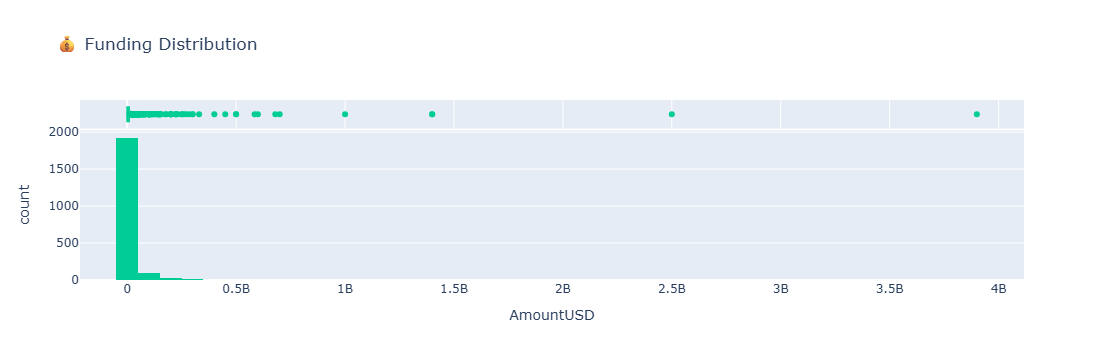

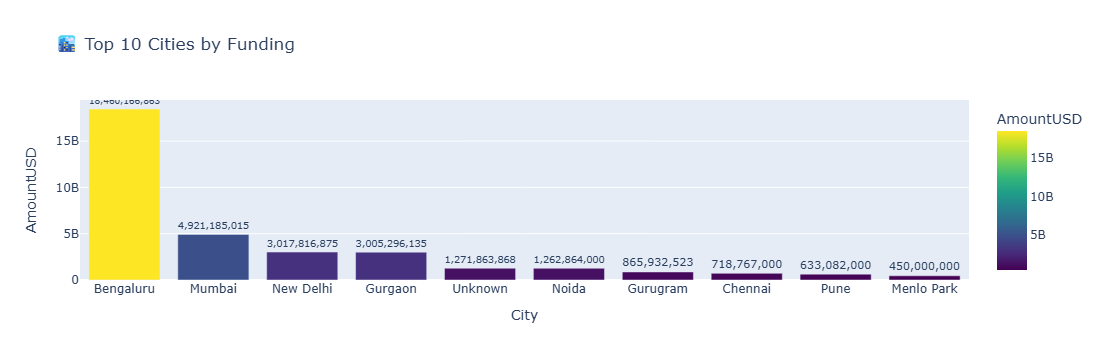

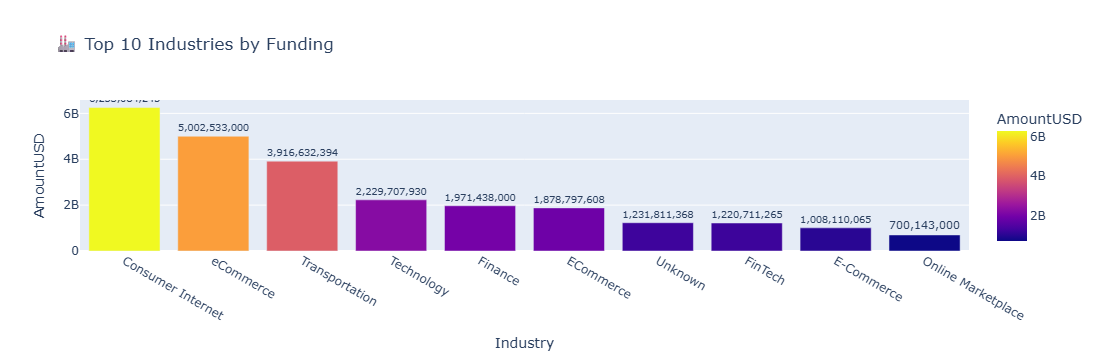

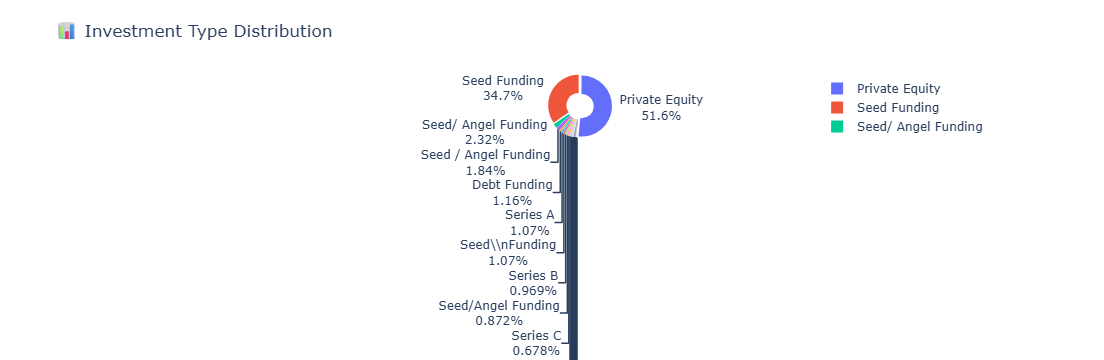

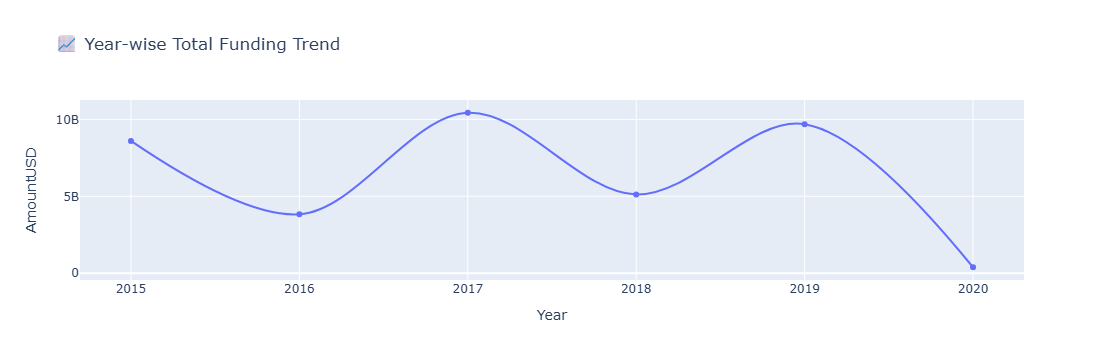

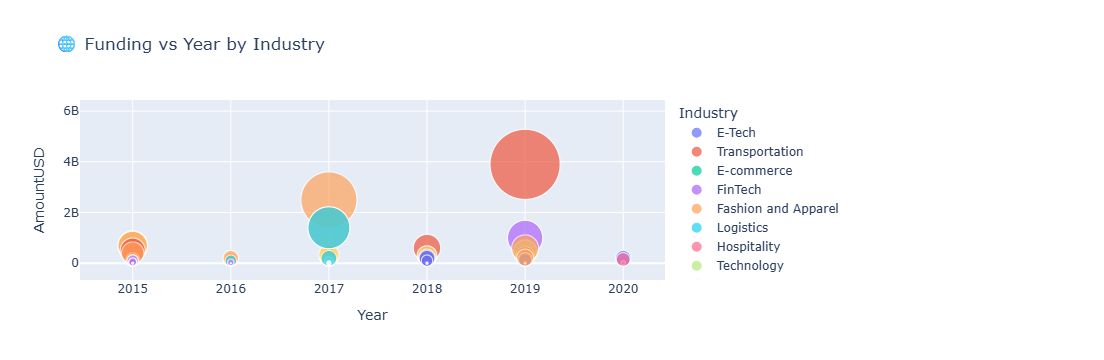

✅ Model Accuracy: 1.0

Confusion Matrix:
 [[201   0]
 [  0 212]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       201
           1       1.00      1.00      1.00       212

    accuracy                           1.00       413
   macro avg       1.00      1.00      1.00       413
weighted avg       1.00      1.00      1.00       413


Example: This startup is predicted as Successful

📌 Insights Summary:

 Top 3 Cities by Total Funding:
   - Bengaluru: $18,460,166,863
   - Mumbai: $4,921,185,015
   - New Delhi: $3,017,816,875

 Top 3 Industries by Total Funding:
   - Consumer Internet: $6,253,084,245
   - eCommerce: $5,002,533,000
   - Transportation: $3,916,632,394

 Most Common Investment Types:
   - Private Equity: 1066 deals
   - Seed Funding: 716 deals
   - Seed/ Angel Funding: 48 deals

 Year with Highest Total Funding: 2017

 Cities with Highest Success Rate:
   - Tulangan: 100.0% successful startups

In [11]:
# -------------------------------
# Startup Growth Analytics Dashboard with Success Prediction & Insights - simple vers
# -------------------------------


import pandas as pd
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


df = pd.read_csv("startup_funding.csv")  
df.columns = ['SrNo','Date','StartupName','Industry','SubVertical','City','Investors','InvestmentType','AmountUSD','Remarks']

df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')
df['AmountUSD'] = pd.to_numeric(df['AmountUSD'].str.replace(',', '', regex=False), errors='coerce')
df = df.dropna(subset=['AmountUSD'])

df['City'] = df['City'].fillna('Unknown').str.strip().replace({'Bangalore':'Bengaluru'})
df['Industry'] = df['Industry'].fillna('Unknown').str.strip()
df['InvestmentType'] = df['InvestmentType'].fillna('Unknown')
df['Year'] = df['Date'].dt.year

# -------------------------------
# EDA Charts
# -------------------------------


fig1 = px.histogram(df, x='AmountUSD', nbins=50,
                    title=' Funding Distribution', marginal='box',
                    color_discrete_sequence=['#00CC96'])
fig1.show()


top_cities = df.groupby('City')['AmountUSD'].sum().sort_values(ascending=False).head(10).reset_index()
fig2 = px.bar(top_cities, x='City', y='AmountUSD', color='AmountUSD', text='AmountUSD',
              title=' Top 10 Cities by Funding', color_continuous_scale=px.colors.sequential.Viridis)
fig2.update_traces(texttemplate='%{text:,.0f}', textposition='outside')
fig2.show()


top_industries = df.groupby('Industry')['AmountUSD'].sum().sort_values(ascending=False).head(10).reset_index()
fig3 = px.bar(top_industries, x='Industry', y='AmountUSD', color='AmountUSD', text='AmountUSD',
              title='🏭 Top 10 Industries by Funding', color_continuous_scale=px.colors.sequential.Plasma)
fig3.update_traces(texttemplate='%{text:,.0f}', textposition='outside')
fig3.show()


inv_counts = df['InvestmentType'].value_counts().reset_index()
inv_counts.columns = ['InvestmentType','Count']
fig4 = px.pie(inv_counts, names='InvestmentType', values='Count',
              title=' Investment Type Distribution', hole=0.4)
fig4.update_traces(textinfo='percent+label', pull=[0.05]*len(inv_counts))
fig4.show()


year_funding = df.groupby('Year')['AmountUSD'].sum().reset_index()
fig5 = px.line(year_funding, x='Year', y='AmountUSD', markers=True,
               title=' Year-wise Total Funding Trend', line_shape='spline')
fig5.show()


fig6 = px.scatter(df, x='Year', y='AmountUSD', size='AmountUSD', color='Industry',
                  hover_data=['StartupName','City'],
                  title=' Funding vs Year by Industry', size_max=70, opacity=0.7)
fig6.show()

# -------------------------------
#  Predict Startup Success
# -------------------------------


df['Success'] = df['AmountUSD'].apply(lambda x: 1 if x > 1000000 else 0)


le_city = LabelEncoder()
df['City_enc'] = le_city.fit_transform(df['City'])

le_industry = LabelEncoder()
df['Industry_enc'] = le_industry.fit_transform(df['Industry'])


X = df[['AmountUSD', 'City_enc', 'Industry_enc']]
y = df['Success']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print(" Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


sample_startup = pd.DataFrame({
    'AmountUSD': [5000000],
    'City_enc': [le_city.transform(['Bengaluru'])[0]],
    'Industry_enc': [le_industry.transform(['E-Tech'])[0]]
})
prediction = model.predict(sample_startup)
print(f"\nExample: This startup is predicted as {'Successful' if prediction[0]==1 else 'Not Successful'}")



print("\n Insights Summary:\n")


print(" Top 3 Cities by Total Funding:")
for idx, row in top_cities.head(3).iterrows():
    print(f"   - {row['City']}: ${row['AmountUSD']:,.0f}")

print("\n Top 3 Industries by Total Funding:")
for idx, row in top_industries.head(3).iterrows():
    print(f"   - {row['Industry']}: ${row['AmountUSD']:,.0f}")


top_investments = inv_counts.head(3)
print("\n Most Common Investment Types:")
for idx, row in top_investments.iterrows():
    print(f"   - {row['InvestmentType']}: {row['Count']} deals")


max_year = year_funding.loc[year_funding['AmountUSD'].idxmax(), 'Year']
print(f"\n Year with Highest Total Funding: {int(max_year)}")


success_rate_city = df.groupby('City')['Success'].mean().sort_values(ascending=False).head(3)
print("\n Cities with Highest Success Rate:")
for city, rate in success_rate_city.items():
    print(f"   - {city}: {rate*100:.1f}% successful startups")

success_rate_ind = df.groupby('Industry')['Success'].mean().sort_values(ascending=False).head(3)
print("\n Industries with Highest Success Rate:")
for ind, rate in success_rate_ind.items():
    print(f"   - {ind}: {rate*100:.1f}% successful startups")

print("\n Recommendation: New startups in top cities and industries, with proper funding, have higher chances of success!")


Note: While I am capable of creating dashboards using Power BI or Tableau, I believe this advanced Dash dashboard in Jupyter effectively demonstrates my skills and is sufficient for this project.